In [2]:
# set wd so we can load the settings.yaml file.
import os
os.chdir("/data/sonakshi/PromptDataExtraction")

In [3]:
import matplotlib.pyplot as plt

In [4]:
import sett
from backend.utils.frame import Frame
from backend.data import mongodb
from backend import postgres
from backend.postgres.orm import PaperTexts, FilteredPapers, Papers, PaperSections
from scripts.parse_error_doi import publishers_directory

2023-09-11 10:59:53,546| ERROR   | Password is required for key /home/sonakshi/.ssh/id_rsa


Load OK: settings.yaml
NOTE  -- postgres_ SSH tunnel established.


In [5]:
sett.load_settings()
postgres.load_settings()
db = postgres.connect()

mongo = mongodb.connect()
collection = mongo["polymer_DOI_records_prod"]

Load OK: settings.yaml


In [33]:
from sqlalchemy import distinct

joined_query = db.query(
    distinct(FilteredPapers.doi),
    Papers.publisher
    ).join(
        Papers, FilteredPapers.doi == Papers.doi
    )

In [34]:
hindawi_dois = joined_query.filter(Papers.publisher == 'Hindawi Limited').all()
len(hindawi_dois)

2605

In [39]:
from sqlalchemy.orm.exc import NoResultFound

df = Frame()

# for each doi, select the document from mongodb
for item in hindawi_dois:
    doi = item[0]
    # paper = Papers().get_one(db,{'doi': doi, 'publisher': 'Hindawi Limited'})
    
    # if paper is None:
    #     continue

    print(doi)

    pgcount = 0
    mgcount = 0

    # count the number of documents in postgres
    paras = PaperTexts().get_all(db, {'doi': doi})
    
    if len(paras) ==0:
        paras = PaperSections().get_all(db, {'doi': doi})

    if paras:
        pgcount = len(paras)

    print("PG count =", pgcount)

    # count the number of documents in mongodb
    document = collection.find_one({'DOI': doi})
    if document:
        fulltext = document.get('full_text')
        for section in fulltext:

            # if section is string
            if type(section) is str:
                if len(section) !=0:
                    mgcount += 1

            #if section is dictionary
            elif type(section) is dict:
                contents = section['content']
                if type(contents) is str and len(contents)>0:
                    mgcount += 1
                else:
                    mgcount += len(contents)

    print("MG count =", mgcount)

    # create a df as doi, pgcount, mgcount
    df.add(doi=doi, pgcount=pgcount, mgcount=mgcount)
            
    # except NoResultFound:
    #     # continue
    #     print(f"No paper found for DOI: {doi}")

#     print(doi)


df.save("parse_papers/full_text_parse/CompareMongo_poly_papers_hindawi_2.csv")


10.1100/2012/167928
PG count = 15
MG count = 29
10.1100/2012/171292
PG count = 15
MG count = 26
10.1100/2012/498503
PG count = 8
MG count = 28
10.1100/2012/680108
PG count = 10
MG count = 18
10.1100/2012/748251
PG count = 13
MG count = 19
10.1155/2007/34527
PG count = 4
MG count = 1
10.1155/2007/38589
PG count = 3
MG count = 1
10.1155/2007/45090
PG count = 4
MG count = 1
10.1155/2007/52729
PG count = 3
MG count = 1
10.1155/2007/74769
PG count = 4
MG count = 4
10.1155/2007/98134
PG count = 3
MG count = 1
10.1155/2008/126803
PG count = 14
MG count = 18
10.1155/2008/276027
PG count = 6
MG count = 22
10.1155/2008/310126
PG count = 5
MG count = 42
10.1155/2008/312792
PG count = 13
MG count = 15
10.1155/2008/415861
PG count = 8
MG count = 14
10.1155/2008/456082
PG count = 8
MG count = 15
10.1155/2008/459093
PG count = 8
MG count = 10
10.1155/2008/470595
PG count = 6
MG count = 13
10.1155/2008/538421
PG count = 7
MG count = 28
10.1155/2008/592838
PG count = 7
MG count = 16
10.1155/2008/609184

In [21]:
db.rollback()

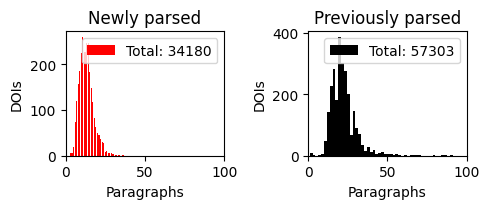

In [41]:
# plot a histogram for pgcount vs mgcount
stats = df.df

fig, ax = plt.subplots(1, 2, figsize=(5, 2.2))
total = stats.pgcount.sum()
ax[0].hist(stats.pgcount, bins=50, color='r', label="Total: %d" %total)

ax[0].legend()
ax[0].set(title="Newly parsed", ylabel="DOIs",
          xlabel="Paragraphs", xlim = (0,100))

total = stats.mgcount.sum()
ax[1].hist(stats.mgcount, bins=50, color='k', label="Total: %d" %total)
ax[1].legend()
ax[1].set(title="Previously parsed", ylabel="DOIs",
          xlabel="Paragraphs", xlim = (0,100))

plt.tight_layout()
plt.savefig("parse_papers/hindawi/CompareMongo_hindawi.png", dpi=600)
plt.show()

In [24]:
len(df.df)

2605

In [ ]:

wiley_dois = joined_query.filter(Papers.publisher.in_(['Wiley', 'Wiley-VCH Verlag GmbH & Co. KGaA'])).all()

print(len(wiley_dois))